In [3]:
%load_ext google.cloud.bigquery

The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery


In [98]:
from solver import BFSAgent, AStarAgent
from sokoban import State
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [6]:
# %reload_ext google.cloud.bigquery

In [7]:
# !pip install --upgrade google-cloud-storage
# !pip install google-cloud-bigquery-storage pyarrow

In [40]:
# CONSTANTS
SUGGESTION_ACCEPT = 'SUGGESTION_ACCEPT'
INTERACTION = 'INTERACTION'
BOARD_CHECKPOINT = 'BOARD_CHECKPOINT'

def format_user_id(n):
    return n
    
    ## WHEN READING FROM CSV ID is mangled, needs this:
# def format_user_id(n):
#     sanitized_n = str(n).replace('.','').replace('e', '').replace('+', '')
#     return sanitized_n[:8]

## Make Pandas DF From UserEvents

In [31]:
%%bigquery users_timestamps_events
SELECT cast(user_pseudo_id as STRING) as user_pseudo_id, event_timestamp, param.value.string_value
FROM `rlbrush-app.analytics_238740288.events_*`,
UNNEST(event_params) as param
WHERE event_name like '%BUTTON_PRESS%'
AND param.key = "label"
ORDER BY user_pseudo_id, event_timestamp ASC

In [32]:
users_timestamps_events

,user_pseudo_id,event_timestamp,string_value
0,1004911408.1596462719,1596462726147229,BRUSH_SIZE
1,1004911408.1596462719,1596462726147229,BRUSH_SIZE
2,1010075655.1596500349,1596500358927949,BRUSH_SIZE
3,1010075655.1596500349,1596500358927949,BRUSH_SIZE
4,1010075655.1596500349,1596500364094321,GRID_TILE_CLICK
...,...,...,...
1665,890902572.1596584093,1596584128664089,PENCIL
1666,895096090.1596461518,1596461523253004,BRUSH_SIZE
1667,895096090.1596461518,1596461523253004,BRUSH_SIZE
1668,912346600.1596493309,1596493314726055,BRUSH_SIZE


# Process User Data

In [22]:
## Get board checkpoints from DB

In [16]:
%%bigquery users_board_states
SELECT event_date, event_timestamp, cast(user_pseudo_id as string) as user_pseudo_id, param.value.string_value
FROM `rlbrush-app.analytics_238740288.events_*`,
UNNEST(event_params) as param
WHERE event_name = "BOARD:CHECKPOINT"
AND param.key = "label"

In [17]:
users_board_states

,event_date,event_timestamp,user_pseudo_id,string_value
0,20200731,1596241784669842,1178513102.1595896751,#######\n# #\n# #\n# @ #\n# #\n#...
1,20200731,1596243530430921,1178513102.1595896751,#######\n# #\n# $ #\n# ..@ #\n# $ #\n#...
2,20200731,1596243576177936,1178513102.1595896751,#######\n# .#\n# $ #\n# ..@ #\n# $ #\n#...
3,20200731,1596243576177936,1178513102.1595896751,#######\n# .#\n# $ .#\n# ..@ #\n# $ #\n#...
4,20200731,1596243581214651,1178513102.1595896751,#######\n# .#\n# $ $#\n# ..@ #\n# $ #\n#...
...,...,...,...,...
467,20200803,1596497076605070,1397870444.1596497072,#######\n# #\n# ## #\n# @# #\n# ### #\n#...
468,20200803,1596497081611623,1397870444.1596497072,#######\n# #\n# ## #\n# @# #\n# ### #\n#...
469,20200803,1596497081611623,1397870444.1596497072,#######\n# #\n# ## #\n# @# #\n# ### #\n#...
470,20200803,1596497081611623,1397870444.1596497072,#######\n# #\n# ## #\n# @# #\n# ### #\n#...


In [23]:
#input file
user_board_states_path = 'data/user_board_states.csv'
#output file
user_board_states_action_sequence_path = 'data/user_board_states_action_sequence.csv'

def clean_board_state_string(s):
    result = s.replace('.9999998', '#') # fixes data collection bug
    return result

def getCompactSolution(array):
    result = []
    for action in array:
        if action['x'] == 1:
            result.append(0)
        elif action['x'] == -1:
            result.append(1)
        elif action['y'] == 1:
            result.append(2)
        elif action['y'] == -1:
            result.append(3)
    return result

with open(user_board_states_path) as f:
#     data = pd.read_csv(f)
    data = users_board_states
    
data['solution'] = ""
bfsSolver = BFSAgent()
for index in data.index:
    inputString = clean_board_state_string(data['string_value'][index])
    playerNumber = inputString.count('@')
    crateNumber = inputString.count('$')
    targetNumber = inputString.count('.')
    if crateNumber > 0 and playerNumber == 1 and targetNumber == crateNumber:
        lines = inputString.split('\n')
        start = State()
        start.stringInitialize(lines)
        sol,_,_ = bfsSolver.getSolution(start)
        data['solution'][index] = str(getCompactSolution(sol));
    else:
        data['solution'][index] = '[]';

# OPTIONAL: write to csv
data.to_csv(user_board_states_action_sequence_path)

/Users/omardelarosa/.pyenv/versions/3.7.7/lib/python3.7/site-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/omardelarosa/.pyenv/versions/3.7.7/lib/python3.7/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [24]:
# preview df
pd.read_csv(user_board_states_action_sequence_path).head()

,Unnamed: 0,event_date,event_timestamp,user_pseudo_id,string_value,solution
0,0,20200731,1596241784669842,1.178513e+09,#######\n# #\n# #\n# @ #\n# #\n#...,[]
1,1,20200731,1596243530430921,1.178513e+09,#######\n# #\n# $ #\n# ..@ #\n# $ #\n#...,"[3, 3, 1, 2, 0, 2, 2, 1, 2, 1, 3]"
2,2,20200731,1596243576177936,1.178513e+09,#######\n# .#\n# $ #\n# ..@ #\n# $ #\n#...,[]
3,3,20200731,1596243576177936,1.178513e+09,#######\n# .#\n# $ .#\n# ..@ #\n# $ #\n#...,[]
4,4,20200731,1596243581214651,1.178513e+09,#######\n# .#\n# $ $#\n# ..@ #\n# $ #\n#...,"[0, 3, 1, 3, 1, 2, 0, 2, 2, 1, 2, 1, 3]"


# Plotting and processing

In [25]:
# user_board_states_action_sequence_path = 'data/user_board_states_action_sequence.csv'
# user_board_states_df = pd.read_csv(user_board_states_action_sequence_path)
user_board_states_df = data # using pandas DF to preserve datatypes
user_board_states_df.head()

,event_date,event_timestamp,user_pseudo_id,string_value,solution
0,20200731,1596241784669842,1178513102.1595896751,#######\n# #\n# #\n# @ #\n# #\n#...,[]
1,20200731,1596243530430921,1178513102.1595896751,#######\n# #\n# $ #\n# ..@ #\n# $ #\n#...,"[3, 3, 1, 2, 0, 2, 2, 1, 2, 1, 3]"
2,20200731,1596243576177936,1178513102.1595896751,#######\n# .#\n# $ #\n# ..@ #\n# $ #\n#...,[]
3,20200731,1596243576177936,1178513102.1595896751,#######\n# .#\n# $ .#\n# ..@ #\n# $ #\n#...,[]
4,20200731,1596243581214651,1178513102.1595896751,#######\n# .#\n# $ $#\n# ..@ #\n# $ #\n#...,"[0, 3, 1, 3, 1, 2, 0, 2, 2, 1, 2, 1, 3]"


In [56]:
len(user_board_states_df)

472

In [66]:
user_board_states_by_user = {}

for idx in user_board_states_df.index:
    user_id = format_user_id(user_board_states_df['user_pseudo_id'][idx])
    if user_id not in user_board_states_by_user:
        user_board_states_by_user[user_id] = []
    timestamp = user_board_states_df['event_timestamp'][idx]
    board_state = user_board_states_df['string_value'][idx]
    solution = user_board_states_df['solution'][idx]
    user_board_states_by_user[user_id].append((timestamp, BOARD_CHECKPOINT, board_state, eval(solution)))
    
print(len(user_board_states_by_user.keys()))

38


In [68]:
# print(user_board_states_by_user)

In [69]:
sessions_by_user = {}

for idx in users_timestamps_events.index:
    user_id = format_user_id(users_timestamps_events['user_pseudo_id'][idx])
    # create events array for user
    if user_id not in sessions_by_user:
        sessions_by_user[user_id] = []
        
    # add interactions
    timestamp = users_timestamps_events['event_timestamp'][idx]
    action_name = users_timestamps_events['string_value'][idx]
    sessions_by_user[user_id].append((timestamp, INTERACTION, action_name))
    
    # add all board states in session
    if user_id in user_board_states_by_user:
        board_states = user_board_states_by_user[user_id]
        for board_state in board_states:
            sessions_by_user[user_id].append(board_state)
    
    sessions_by_user[user_id] = sorted(sessions_by_user[user_id], key=lambda x: x[0])

In [70]:
print("num_total_sessions: ", len(sessions_by_user.keys()))

num_total_sessions:  39


In [36]:
# print(sessions_by_user['10049114'])

In [252]:
## Average Session Duration

MAX_SOLUTION_LENGTH = 35

cols = [
    'user_id',
    'total_interactions',
    'total_suggestion_interactions',
    'rate_of_ai_suggestion',
    'first_interaction_time',
    'last_interaction_time',
    'first_suggestion_interaction_time',
    'norm_first_suggestion_interaction_time',
    'num_valid_board_checkpoints',
    'total_board_checkpoints',
    'board_valid_rate',
    'first_valid_board_checkpoints_interaction_time',
    'norm_first_valid_board_checkpoints_interaction_time',
    'max_solution_length',
    'max_solution_complexity'
]

session_metrics_df = pd.DataFrame([], columns=cols)

def get_normalized_interaction_time(min_time, max_time, interaction_time):
    total_time = max_time - min_time
    rem_time = max_time - interaction_time
    duration = total_time - rem_time
    return duration / total_time

for user_id in sessions_by_user:
    session_events = sessions_by_user[user_id]
    # count user interactions with UI buttons, elements etc.  exclude checkpoint events
    total_interactions = len([ev[0] for ev in session_events if ev[1] == INTERACTION])
    first_interaction_time = session_events[0][0]
    last_interaction_time = session_events[-1][0]
    suggestion_interactions = [ev[0] for ev in session_events if ev[2] == SUGGESTION_ACCEPT]
    total_suggestion_interactions = len(suggestion_interactions)
    
    rate_of_ai_suggestion = total_suggestion_interactions / total_interactions
    
    # check for when first suggestion was found
    first_suggestion_interaction_time = None
    if suggestion_interactions:
        first_suggestion_interaction_time = suggestion_interactions[0]
    
    norm_first_suggestion_interaction_time = -1.0
    if first_suggestion_interaction_time:
        norm_first_suggestion_interaction_time = get_normalized_interaction_time(
            first_interaction_time, 
            last_interaction_time, 
            first_suggestion_interaction_time
        )
    
    # check when first valid board was constructed
    first_valid_board_interaction_time = None
    norm_first_valid_board_interaction_time = -1.0
    
    valid_boards = [ev for ev in session_events if (ev[1] == BOARD_CHECKPOINT and len(ev[3]) > 0)]
    all_boards = [ev for ev in session_events if (ev[1] == BOARD_CHECKPOINT)]
    num_valid_boards = len(valid_boards)
    total_boards = len(all_boards)
    
    if num_valid_boards:
        first_valid_board_interaction_time = valid_boards[0][0]
    
    if first_valid_board_interaction_time:
        norm_first_valid_board_interaction_time = get_normalized_interaction_time(
            first_interaction_time, 
            last_interaction_time, 
            first_valid_board_interaction_time
        )
    
    board_valid_rate = 0.0
    max_solution_length = 0
    if total_boards:
        board_valid_rate = num_valid_boards / total_boards
        max_solution_length = max([len(ev[3]) for ev in all_boards])
    
    max_solution_complexity = max_solution_length / MAX_SOLUTION_LENGTH
    
    row = [[
        user_id,
        total_interactions,
        total_suggestion_interactions,
        rate_of_ai_suggestion,
        first_interaction_time,
        last_interaction_time,
        first_suggestion_interaction_time,
        norm_first_suggestion_interaction_time,
        num_valid_boards,
        total_boards,
        board_valid_rate,
        first_valid_board_interaction_time,
        norm_first_valid_board_interaction_time,
        max_solution_length,
        max_solution_complexity
    ]]
    row_df = pd.DataFrame(row, columns=cols)
    session_metrics_df = session_metrics_df.append(row_df)

In [253]:
session_metrics_df

,user_id,total_interactions,total_suggestion_interactions,rate_of_ai_suggestion,first_interaction_time,last_interaction_time,first_suggestion_interaction_time,norm_first_suggestion_interaction_time,num_valid_board_checkpoints,total_board_checkpoints,board_valid_rate,first_valid_board_checkpoints_interaction_time,norm_first_valid_board_checkpoints_interaction_time,max_solution_length,max_solution_complexity
0,1004911408.1596462719,2,0,0.000000,1596462726147229,1596462726147229,None,-1.000000,0,2,0.000000,None,-1.000000,0,0.000000
0,1010075655.1596500349,9,0,0.000000,1596500358927949,1596500371769915,None,-1.000000,0,27,0.000000,None,-1.000000,0,0.000000
0,1077578486.1596433276,2,0,0.000000,1596433281682939,1596433281682939,None,-1.000000,0,2,0.000000,None,-1.000000,0,0.000000
0,1084056299.1596436254,36,2,0.055556,1596436259703755,1596436308804264,1596436285215744,0.519587,0,648,0.000000,None,-1.000000,0,0.000000
0,1120019585.1596437267,16,3,0.187500,1596437276457333,1596437300448376,1596437300448376,1.000000,32,64,0.500000,1596437300448376,1.000000,11,0.314286
0,1149737756.1596043521,49,0,0.000000,1596043526910883,1596043708407957,None,-1.000000,0,686,0.000000,None,-1.000000,0,0.000000
0,1178513102.1595896751,160,41,0.256250,1596241784669842,1596586468737455,1596243522046307,0.005040,1920,9600,0.200000,1596243530430921,0.005065,31,0.885714
0,1233118574.1596426303,2,0,0.000000,1596426307715411,1596426307715411,None,-1.000000,0,2,0.000000,None,-1.000000,0,0.000000
0,1299520380.1596426784,30,11,0.366667,1596426789882274,1596426948599910,1596426910113751,0.757518,30,330,0.090909,1596426922526825,0.835727,17,0.485714
0,1353504925.1596409161,2,0,0.000000,1596409168255142,1596409168255142,None,-1.000000,0,2,0.000000,None,-1.000000,0,0.000000


In [254]:
len(session_metrics_df)

39

In [251]:
session_metrics_df.to_csv('data/sessions_metrics.csv')

## Metrics By User Cohort

In [319]:
# aggregations
def get_average_valid_board_rate(df):
    average_valid_board_rate = sum(df["board_valid_rate"]) / len(df)
    print("average_valid_board_rate: {}".format(average_valid_board_rate))
    return average_valid_board_rate
    
def get_average_time_to_first_valid_board(df):
    average_time_to_first_valid_board = abs(sum(df["norm_first_valid_board_checkpoints_interaction_time"]) / len(df))
    print("average_time_to_first_valid_board: {}".format(average_time_to_first_valid_board))
    return average_time_to_first_valid_board

def get_average_time_to_first_ai_suggestion(df):
    average_time_to_first_ai_suggestion = sum(df["norm_first_suggestion_interaction_time"]) / len(df)
    # skip negative values, kind of like a RELU
    if average_time_to_first_ai_suggestion < 0.0:
        average_time_to_first_ai_suggestion = 0.0
    print("average_time_to_first_ai_suggestion: {}".format(average_time_to_first_ai_suggestion))
    return average_time_to_first_ai_suggestion
    

In [337]:
# only considering those with at least 1 valid board
all_users = session_metrics_df[session_metrics_df["norm_first_valid_board_checkpoints_interaction_time"] >= 0.0]
all_users_unfiltered = session_metrics_df

with_ai = all_users[all_users["norm_first_suggestion_interaction_time"] > 0.0]
without_ai = all_users[all_users["norm_first_suggestion_interaction_time"] < 0.0]

#### All Users

In [338]:
metrics_for_subset(session_metrics_df)

average_valid_board_rate: 0.0706242348244386
average_time_to_suggestion: -0.3279486544346861


#### With AI

In [339]:
metrics_for_subset(with_ai)

average_valid_board_rate: 0.260454305321855
average_time_to_suggestion: 0.4443384470598639


#### Without AI

In [340]:
metrics_for_subset(without_ai)

average_valid_board_rate: 0.20512820512820512
average_time_to_suggestion: -1.0


In [341]:
labels = [
    'All',
    'With AI',
    'Without AI',
]

average_valid_board_rates = [
    int(get_average_valid_board_rate(all_users) * 100),
    int(get_average_valid_board_rate(with_ai) * 100),
    int(get_average_valid_board_rate(without_ai) * 100)
]

average_time_to_first_valid_board = [
    int(get_average_time_to_first_valid_board(all_users) * 100),
    int(get_average_time_to_first_valid_board(with_ai) * 100),
    int(get_average_time_to_first_valid_board(without_ai) * 100)
]

average_time_to_first_ai_suggestion = [
    int(get_average_time_to_first_ai_suggestion(all_users) * 100),
    int(get_average_time_to_first_ai_suggestion(with_ai) * 100),
    int(get_average_time_to_first_ai_suggestion(without_ai) * 100)
]

average_valid_board_rate: 0.250395014377555
average_valid_board_rate: 0.260454305321855
average_valid_board_rate: 0.20512820512820512
average_time_to_first_valid_board: 0.3945313094552454
average_time_to_first_valid_board: 0.337814129522055
average_time_to_first_valid_board: 0.6497586191546025
average_time_to_first_ai_suggestion: 0.1817314566853432
average_time_to_first_ai_suggestion: 0.4443384470598639
average_time_to_first_ai_suggestion: 0.0


In [342]:
def plotter(labels, ys, ys2, xlabel1, xlabel2,  ylabel, title):
    
    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, ys, width, label=xlabel1)
    rects2 = ax.bar(x + width/2, ys2, width, label=xlabel2)
    
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()


    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')


    autolabel(rects1)
    autolabel(rects2)

    fig.tight_layout()

    plt.show()

In [343]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

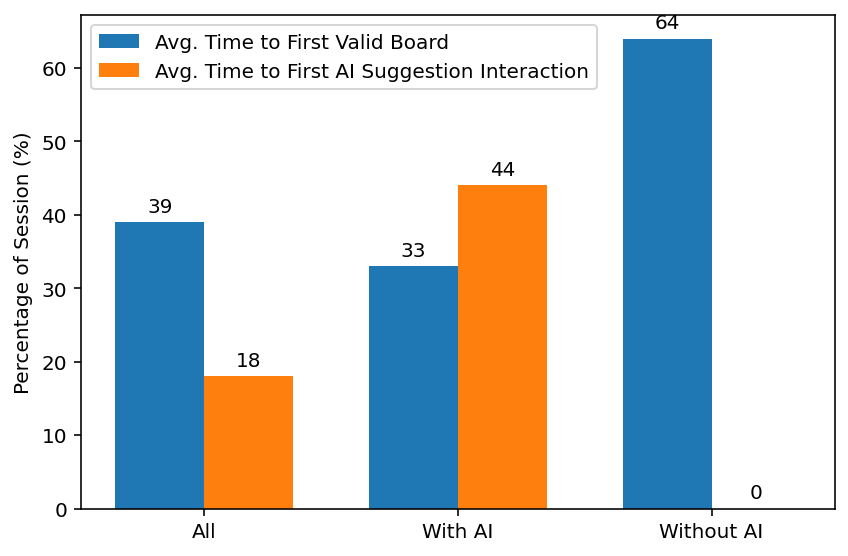

In [344]:
plotter(
    labels, 
    average_time_to_first_valid_board, 
    average_time_to_first_ai_suggestion, 
    "Avg. Time to First Valid Board", 
    "Avg. Time to First AI Suggestion Interaction", 
    "Percentage of Session (%)", 
    ""
)

In [273]:
# all_users_unfiltered = session_metrics_df
# all_users_unfiltered = with_ai

In [398]:
# list(all_users_unfiltered["max_solution_length"])

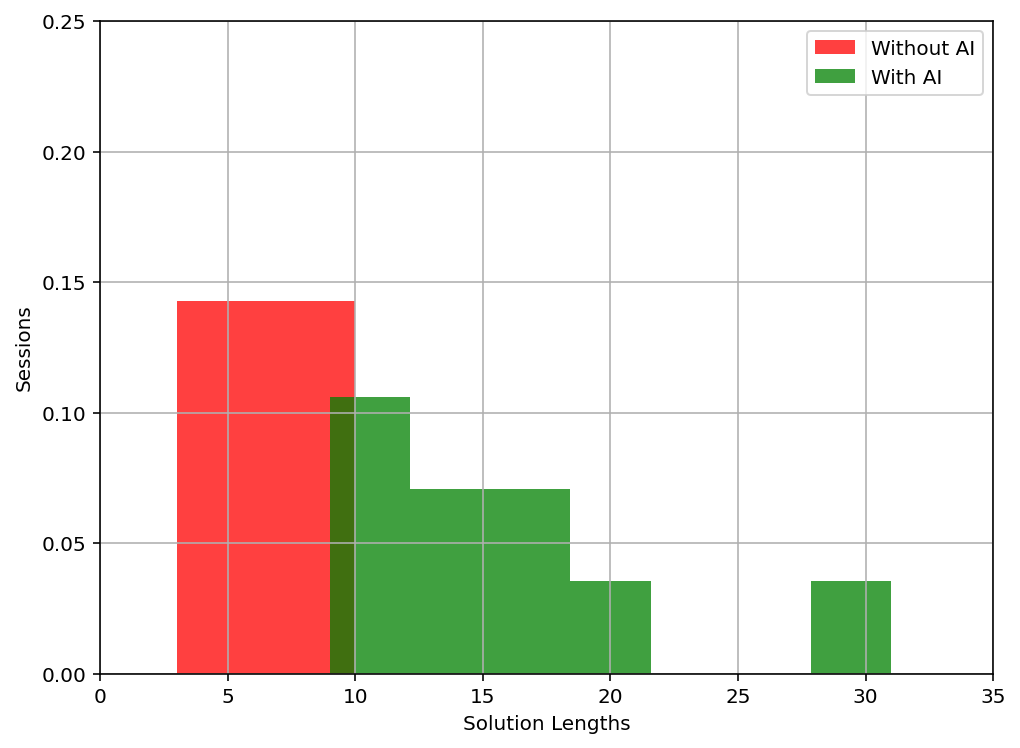

In [374]:
# the histogram of the data

x1 = np.array(without_ai["max_solution_length"])
x2 = np.array(with_ai["max_solution_length"])

plt.figure(figsize=(8,6))
n, bins, patches = plt.hist(x1, len(set(x1)), density=True, facecolor='r', alpha=0.75, label='Without AI')
n, bins, patches = plt.hist(x2, len(set(x2)), density=True, facecolor='g', alpha=0.75, label='With AI')

plt.xlabel('Solution Lengths')
plt.ylabel('Sessions')
plt.title('')
plt.xlim(0, 35)
plt.ylim(0, 0.25)
plt.grid(True)
plt.legend(loc='upper right')
plt.show()


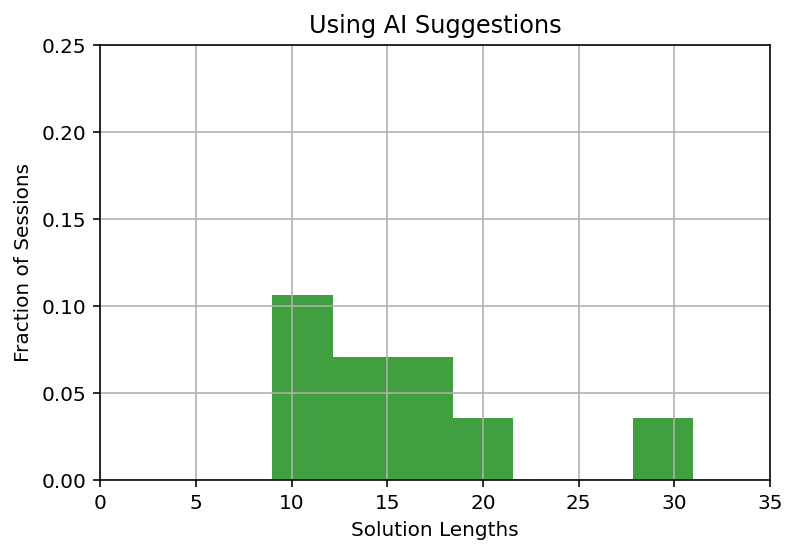

In [352]:
# the histogram of the data


plt.xlabel('Solution Lengths')
plt.ylabel('Fraction of Sessions')
plt.title('Using AI Suggestions')
plt.xlim(0, 35)
plt.ylim(0, 0.25)
plt.grid(True)
plt.show()

In [360]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

11
11
Coefficients: 
 [0.30568359]


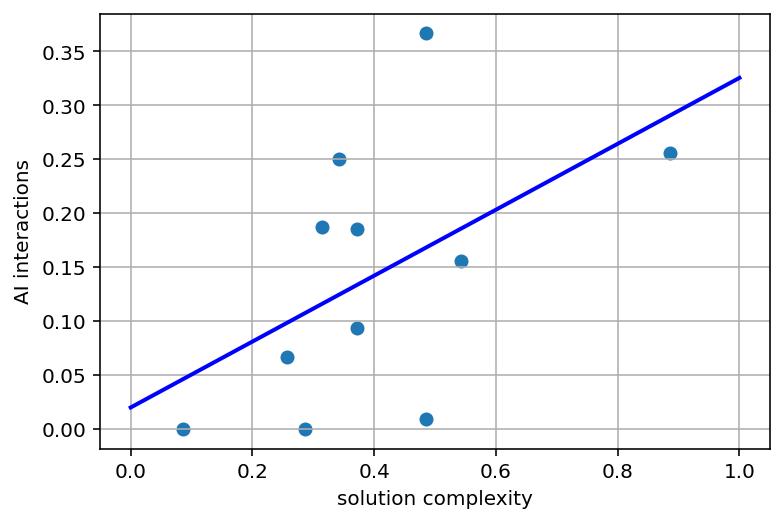

In [401]:
u_segment = all_users

x = np.array(u_segment["max_solution_complexity"])
y = np.array(u_segment["rate_of_ai_suggestion"])

print(len(x))
print(len(y))

# Create linear regression object
regr = linear_model.LinearRegression()
x_train = x.reshape(-1, 1)
regr.fit(x_train, y)
xs_pred = np.linspace(0,1.0,100)
xs_pred = xs_pred.reshape(-1, 1)
ys_pred = regr.predict(xs_pred)

print('Coefficients: \n', regr.coef_)

fig, ax = plt.subplots()
ax.scatter(x, y)
ax.plot(xs_pred, ys_pred, color='blue', linewidth=2)
# ax.text(60, .025, r'\$text{foo}$')
ax.set(xlabel='solution complexity', ylabel='AI interactions',
       title='')
ax.grid()

# fig.savefig("test.png")
plt.show()

Coefficients: 
 [0.27947319]


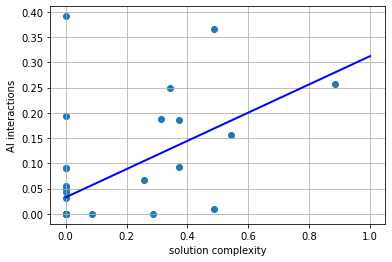

In [317]:
u_segment = all_users_unfiltered

x = np.array(u_segment["max_solution_complexity"])
y = np.array(u_segment["rate_of_ai_suggestion"])

# Create linear regression object
regr = linear_model.LinearRegression()
x_train = x.reshape(-1, 1)
regr.fit(x_train, y)
xs_pred = np.linspace(0,1.0,100)
xs_pred = xs_pred.reshape(-1, 1)
ys_pred = regr.predict(xs_pred)

print('Coefficients: \n', regr.coef_)

fig, ax = plt.subplots()

ax.scatter(x, y)
ax.plot(xs_pred, ys_pred, color='blue', linewidth=2)

ax.set(xlabel='solution complexity', ylabel='AI interactions',
       title='')
ax.grid()

# fig.savefig("test.png")
plt.show()

In [400]:
print(len(np.array(u_segment["max_solution_complexity"])))
print(len(np.array(u_segment["rate_of_ai_suggestion"])))

39
39


In [377]:
%%bigquery users_agents
SELECT event_date, event_timestamp, cast(user_pseudo_id as string), param.value.string_value
FROM `rlbrush-app.analytics_238740288.events_*`,
UNNEST(event_params) as param
WHERE event_name = "EDITOR:ACCEPT_GHOST_SUGGESTION"
AND param.key = "label"

In [379]:
print(users_agents)

    event_date   event_timestamp                    f0_ string_value
0     20200803  1596437300448376  1120019585.1596437267       turtle
1     20200803  1596437300448376  1120019585.1596437267       narrow
2     20200803  1596437300448376  1120019585.1596437267     majority
3     20200803  1596448649682245  1475981336.1596448604       turtle
4     20200803  1596448654808117  1475981336.1596448604       turtle
..         ...               ...                    ...          ...
208   20200804  1596584471490162  1371246741.1596584431         wide
209   20200804  1596584531995623  1371246741.1596584431         wide
210   20200804  1596584641048890  1371246741.1596584431         wide
211   20200804  1596584641048890  1371246741.1596584431         wide
212   20200804  1596584647872680  1371246741.1596584431         wide

[213 rows x 4 columns]


In [383]:
agents_counts = Counter(list(users_agents["string_value"]))

In [384]:
agents_counts

Counter({'turtle': 35, 'narrow': 26, 'majority': 96, 'wide': 56})

In [386]:
labels = list(agents_counts.keys())
print(labels)

['turtle', 'narrow', 'majority', 'wide']


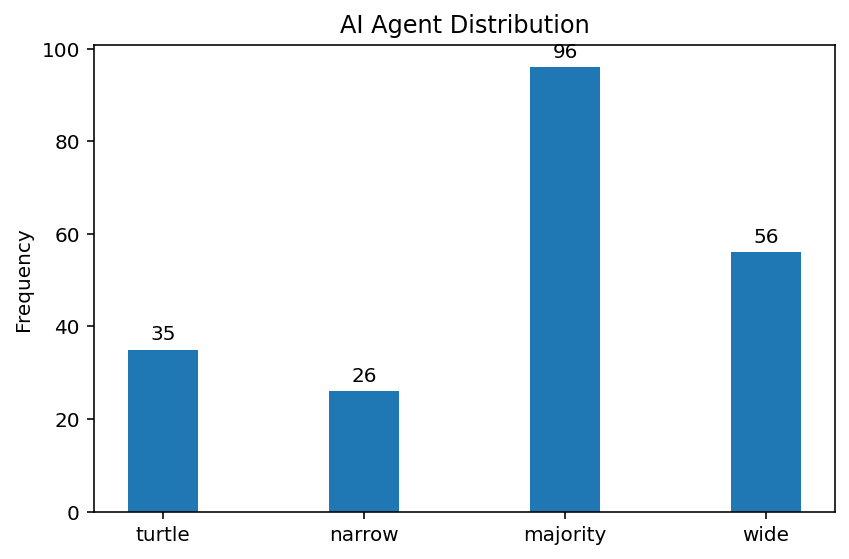

In [397]:
title = 'AI Agent Distribution'
ylabel = 'Frequency'

x = np.arange(0, len(labels))
ys = [agents_counts[l] for l in labels]
width = 0.35
# plt.bar(x - width/2, ys, width, label='foo')

# Add some text for labels, title and custom x-axis tick labels, etc.
fig, ax = plt.subplots()
res = ax.bar(x, ys, width, label='Number of clicks')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel(ylabel)
ax.set_title(title)
ax.set_xticks(x)
ax.set_xticklabels(labels)
# ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(res)

fig.tight_layout()

plt.show()

In [419]:
# AI: true, Playable: true
df = all_users_unfiltered
df1 = df[df["total_suggestion_interactions"] > 0]
df2 = df1[df1["max_solution_length"] > 0]
print("AI: true, Playable: true:", len(df2))

AI: true, Playable: true: 9


In [420]:
# AI: false, Playable: true
df = all_users_unfiltered
df1 = df[df["total_suggestion_interactions"] <= 0]
df2 = df1[df1["max_solution_length"] > 0]
print("AI: false, Playable: true:", len(df2))

AI: false, Playable: true: 2


In [421]:
# AI: false, Playable: false
df = all_users_unfiltered
df1 = df[df["total_suggestion_interactions"] <= 0]
df2 = df1[df1["max_solution_length"] <= 0]
print("AI: false, Playable: false:", len(df2))

AI: false, Playable: false: 20


In [422]:
# AI: true, Playable: false
df = all_users_unfiltered
df1 = df[df["total_suggestion_interactions"] > 0]
df2 = df1[df1["max_solution_length"] <= 0]
print(" AI: true, Playable: false:", len(df2))

 AI: true, Playable: false: 8


In [414]:
all_users_unfiltered

,user_id,total_interactions,total_suggestion_interactions,rate_of_ai_suggestion,first_interaction_time,last_interaction_time,first_suggestion_interaction_time,norm_first_suggestion_interaction_time,num_valid_board_checkpoints,total_board_checkpoints,board_valid_rate,first_valid_board_checkpoints_interaction_time,norm_first_valid_board_checkpoints_interaction_time,max_solution_length,max_solution_complexity
0,1004911408.1596462719,2,0,0.000000,1596462726147229,1596462726147229,None,-1.000000,0,2,0.000000,None,-1.000000,0,0.000000
0,1010075655.1596500349,9,0,0.000000,1596500358927949,1596500371769915,None,-1.000000,0,27,0.000000,None,-1.000000,0,0.000000
0,1077578486.1596433276,2,0,0.000000,1596433281682939,1596433281682939,None,-1.000000,0,2,0.000000,None,-1.000000,0,0.000000
0,1084056299.1596436254,36,2,0.055556,1596436259703755,1596436308804264,1596436285215744,0.519587,0,648,0.000000,None,-1.000000,0,0.000000
0,1120019585.1596437267,16,3,0.187500,1596437276457333,1596437300448376,1596437300448376,1.000000,32,64,0.500000,1596437300448376,1.000000,11,0.314286
0,1149737756.1596043521,49,0,0.000000,1596043526910883,1596043708407957,None,-1.000000,0,686,0.000000,None,-1.000000,0,0.000000
0,1178513102.1595896751,160,41,0.256250,1596241784669842,1596586468737455,1596243522046307,0.005040,1920,9600,0.200000,1596243530430921,0.005065,31,0.885714
0,1233118574.1596426303,2,0,0.000000,1596426307715411,1596426307715411,None,-1.000000,0,2,0.000000,None,-1.000000,0,0.000000
0,1299520380.1596426784,30,11,0.366667,1596426789882274,1596426948599910,1596426910113751,0.757518,30,330,0.090909,1596426922526825,0.835727,17,0.485714
0,1353504925.1596409161,2,0,0.000000,1596409168255142,1596409168255142,None,-1.000000,0,2,0.000000,None,-1.000000,0,0.000000
